In [1]:
import requests
import io
import zipfile

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart

# Na początku robimy to samo co w pracy domowej 1

tylko tym razem w Pythonie...

In [2]:
url = 'https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as tmp_zip:
    for zip_file in tmp_zip.infolist():
        with tmp_zip.open(zip_file, 'r') as f:
            stata_file = io.BytesIO(f.read())

In [3]:
stata_file.seek(0)
data = pd.read_stata(stata_file)

# Obrabiamy dane jak poprzednio


In [4]:
data = data[['S1', 'Q9', 'Q19', 'Q26', 'ppage']]

In [5]:
for column in data.columns:
    data = data[data[column] != 'Refused']
    data[column].cat.remove_unused_categories()
data = data.dropna()
data[['Q9', 'ppage']] = data[['Q9', 'ppage']].apply(pd.to_numeric, axis=1)

In [6]:
data.sample(5)

,S1,Q9,Q19,Q26,ppage
237,"Yes, I am Married",55.0,Yes,Did not attend same college or university,49.0
1513,"Yes, I am Married",55.0,Yes,Did not attend same college or university,55.0
1808,"No, I am not Married",74.0,No,Did not attend same college or university,72.0
1753,"Yes, I am Married",60.0,Yes,Did not attend same college or university,63.0
3050,"Yes, I am Married",53.0,Yes,Did not attend same college or university,50.0


In [7]:
y = data['S1']
x = data.drop('S1', axis=1)

# Robimy model

In [8]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

le_q19 = LabelEncoder()
x['Q19'] = le_q19.fit_transform(x['Q19'])

le_q26 = LabelEncoder()
x['Q26'] = le_q26.fit_transform(x['Q26'])

In [9]:
ohe = OneHotEncoder(categorical_features=[1, 2], 
                    dtype=np.int64,
                    sparse=False)
x = pd.DataFrame(ohe.fit_transform(x.values))
x.columns = ['Q9_0', 'Q9_1', 'Q19_0', 'Q19_1', 'Q26', 'ppage']

In [10]:
x.drop(['Q9_0', 'Q19_0'], axis=1, inplace=True)
x.head()

,Q9_1,Q19_1,Q26,ppage
0,1.0,1.0,52.0,55.0
1,1.0,1.0,45.0,47.0
2,1.0,1.0,59.0,59.0
3,1.0,1.0,65.0,65.0
4,1.0,1.0,43.0,33.0


In [11]:
rfc = RandomForestClassifier(max_depth=4,
                             n_estimators=30,
                             max_features=None)
rfc.fit(x, y)

y_pred = rfc.predict(x)
accuracy_score(y, y_pred)

0.8761844598862919

# Wyjaśniamy model przez variable attribution

In [12]:
class MeanPredictionChangePlotter(object):
    def __init__(self, clf, x):
        self.clf = clf
        self.x = x
        
    def draw_mean_prediction_change_plot(self, observation, *args):
        # compute prediction means and differences between them
        tmp = self.x.copy()
        means = []
        names = []
        names.append('sample_mean')
        mean = self.clf.predict_proba(tmp)[:, 1]\
                       .mean()
        means.append(mean)
        
        for arg in args:
            tmp[arg] = observation[arg].values[0]
            mean = self.clf.predict_proba(tmp)[:, 1]\
               .mean()
            means.append(mean)
            names.append(arg)
            
        means = np.concatenate((np.array([means[0]]), np.diff(np.array(means))))
        
        # draw the plot
        waterfall_chart.plot(names, 
                             means,
                             formatting='{:,.3f}',
                             rotation_value=90)
        
        return


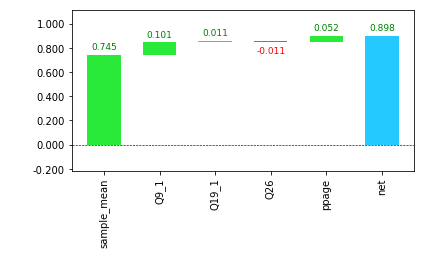

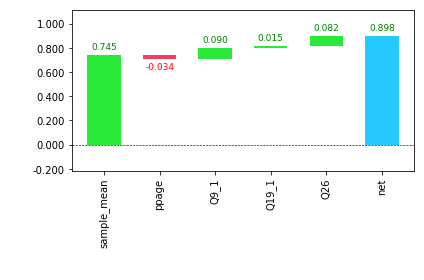

In [13]:
joe = pd.DataFrame({'Q9_0': [0], 'Q9_1': [1], 'Q19_0': [1], 'Q19_1': [0], 'Q26': [40], 'ppage': [41]})

mpcp = MeanPredictionChangePlotter(rfc, x)
mpcp.draw_mean_prediction_change_plot(joe, 'Q9_1', 'Q19_1', 'Q26', 'ppage')
mpcp.draw_mean_prediction_change_plot(joe,  'ppage', 'Q9_1', 'Q19_1', 'Q26')

Rozważono dwie kolejności zmiennych:

* Najpierw zmienne jakościowe, następnie ciągłe
* Najpierw jedna zmienna ciągła, następnie jakościowe i pozostałe ciągłe

Ciekawą obserwacją są kierunki zmian średnich predykcji przy ustalaniu zmiennych ciągłych. Przy ustaleniu zmiennej ppage na samym końcu mamy dość silną dodatnią zmianę. Natomiast przy zamrożeniu zmiennej 'ppage' na samym początku otrzymujemy efekt w kierunku ujemnym! Również druga ze zmiennych zmienia znak w obydwu przypadkach. Może to mieć związek z wysokim skorelowaniem wieku partnerów.

